In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
import warnings
import json
from scorer import ScorerInfo
from pathlib import Path
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "is_sparse")


In [4]:
calcs = {'auROC': ScorerInfo("prroc_rocauc", "rocauc").make(),
         'auPRC': ScorerInfo("prroc_prauc", "prauc", params={"type": "integral"}).make()}

In [5]:
# model_name, version = 'MYPOP-CHS-GHTS-2', 0
# # model_name, version, run_descr = 'only_one_exp', 0, 'BATF2 GHTS/GHTS'
# path_to_model = '/home/nikgr/mex_models/shades_one_5/%s' % model_name
# path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
# path_to_preds = path_to_model + '/model/predictions_new_format_%s.tsv'
# path_to_conf = path_to_model + '/config.json'
# model_full_descr = 'LegNet (%s)' % (model_name)

In [6]:

# model_name, version = 'GABPA-CHS-GHTS-1', 0
# # model_name, version, run_descr = 'only_one_exp', 0, 'BATF2 GHTS/GHTS'
# path_to_model = '/home/nikgr/mex_models_prod/shades_one_run/%s' % model_name
# path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
# path_to_preds = path_to_model + '/model/predictions_new_format_%s.tsv'
# path_to_conf = path_to_model + '/config.json'
# model_full_descr = 'LegNet (%s)' % (model_name)

In [7]:
model_name, version = 'ZNF226-CHS-GHTS-1', 0
path_to_model = '/home/nikgr/mex_models/multitesting_test/%s' % model_name
path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
path_to_preds = path_to_model + '/model' #'/model/predictions_new_format.tsv'
path_to_conf = path_to_model + '/config.json'
model_full_descr = 'LegNet (%s)' % (model_name)

In [8]:
print(path_to_conf)
with open(path_to_conf) as f:
    model_config = json.load(f)
print(model_config)

/home/nikgr/mex_models/multitesting_test/ZNF226-CHS-GHTS-1/config.json
{'stem_ch': 80, 'stem_ks': 40, 'ef_ks': 9, 'ef_block_sizes': [80, 96, 112, 128], 'resize_factor': 4, 'pool_sizes': [2, 2, 2, 2], 'reverse_augment': True, 'use_reverse_channel': False, 'use_shift': True, 'max_shift': [25, 25], 'max_lr': 0.0025, 'weight_decay': 0.1, 'model_dir': '/home/nikgr/mex_models/multitesting_test/ZNF226-CHS-GHTS-1', 'train_path': '/home/nikgr/MEX/DATASETS/CHS/Train/ZNF226', 'ref_genome_path': '/home/nikgr/hg38/hg38.fa', 'valid_path': '/home/nikgr/MEX/DATASETS/CHS/Test/ZNF226', 'test_path': '/home/nikgr/MEX/DATASETS/GHTS/Test/ZNF226', 'epoch_num': 10, 'device': 0, 'seed': 777, 'train_batch_size': 1024, 'valid_batch_size': 1024, 'num_workers': 24, 'training': True, 'negatives': ['random'], 'negatives_test': ['foreigns'], 'pwms_path': '/home/nikgr/MEX/best_20_motif_CHS_GHTS/CHS/ZNF226', 'pwms_freeze': True, 'pwm_loc': 'edge', 'model_type': 'LegNet'}


In [9]:
def get_mod_info(conf):
    aug = []
    if conf['reverse_augment']:
        aug.append('rev')
    if conf['use_shift']:
        # aug.append(f'{conf["max_shift"][0]}-{conf["max_shift"][1]} shift')
        aug.append(f'{conf["max_shift"][0]} shift')
    if len(aug) == 0:
        aug.append('w/o aug')
    else:
        aug[0] = 'with ' + aug[0]
        aug[-1] = aug[-1] + ' aug'
    aug = ' & '.join(aug)
    neg = ' & '.join(conf['negatives']) + ' neg.'
    ep_n = f'{conf["epoch_num"]} ep.'
    return f'LegNet ' + ', '.join([aug, neg, ep_n])

def get_run_info(conf):
    train_split = conf["train_path"].split("/")
    return f'{train_split[-1]} {train_split[-3]}/{conf["test_path"].split("/")[-3]}'

mod_info = get_mod_info(model_config)
run_info = get_run_info(model_config)
print(mod_info)
print(run_info)

LegNet with rev & 25 shift aug, random neg., 10 ep.
ZNF226 CHS/GHTS


In [10]:
metrics_df = pd.read_csv(path_to_metrics, sep=',')
left_df = metrics_df[['val_loss', 'val_auroc', 'epoch', 'step']].dropna()
right_df = metrics_df[['epoch', 'step', 'train_loss']].dropna()
metrics_df = pd.merge(left_df, right_df, on=['epoch', 'step'])
metrics_df.tail()

,val_loss,val_auroc,epoch,step,train_loss
5,0.037640,0.799159,5,209,0.039028
6,0.035570,0.871791,6,244,0.036755
7,0.033406,0.887840,7,279,0.032667
8,0.031441,0.904681,8,314,0.031239
9,0.031128,0.904055,9,349,0.029719


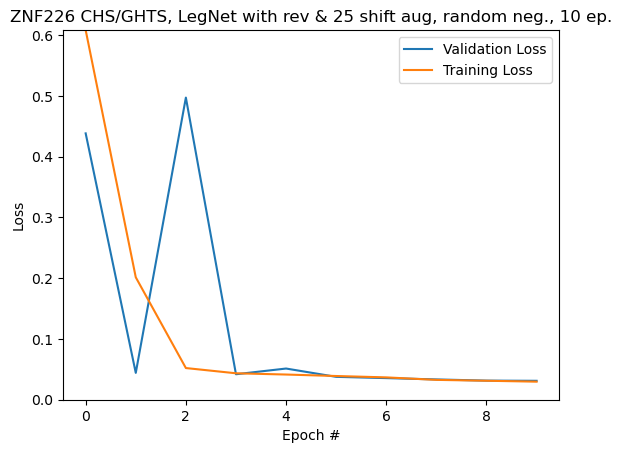

In [11]:
ax = plt.axes()
ax.set_ylim(0, max(metrics_df['val_loss'].max(), metrics_df['train_loss'].max()))
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss')
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(loc='upper right')
plt.show()


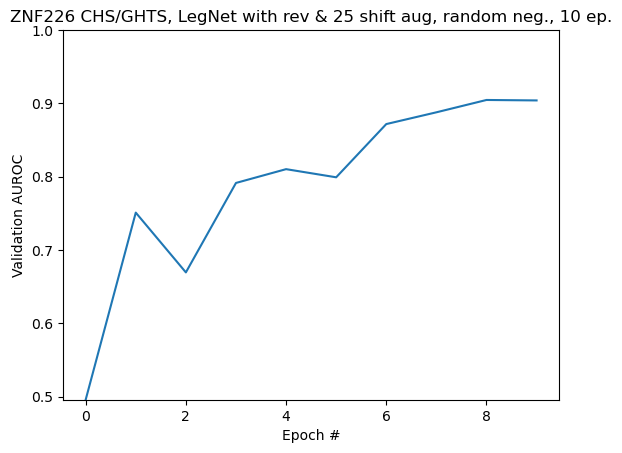

In [12]:
ax = plt.axes()
ax.set_ylim(metrics_df['val_auroc'].min(), 1)
# ax.set_ylim(0.8, 1)
plt.plot(metrics_df['epoch'], metrics_df['val_auroc'])
plt.title('%s, %s' % (run_info, mod_info))
plt.ylabel('Validation AUROC')
plt.xlabel('Epoch #')
plt.show()

In [13]:
preds = ('forw_pred', 'avg_pred', 'rev_pred')
preds_names = {'forw_pred': 'forward', 'rev_pred': 'reverse', 'avg_pred': 'averaged'}
def process_preds_df(path, split, old=False):
    preds_df = pd.read_csv(path % split if not old else path, sep='\t')
    preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
    return preds_df

In [14]:
def process_multitesting_preds_df(path):
    if isinstance(path, str):
        path = Path(path)
    files = path.rglob('*.tsv')
    for file in files:
        if 'predictions' not in file.stem:
            continue
        name_components = file.stem.split('_')
        preds_df = pd.read_csv(file, sep='\t')
        preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
        yield (preds_df, name_components[3], name_components[4])

In [28]:
def plot_roc(preds_df, split, negative='', ax=None, title=None):
    ax_wasnt_set = ax is None
    ax = plt.axes() if ax_wasnt_set else ax
    ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    title = f'ROC on {run_info}, {mod_info} [{split} {negative}]' if title is None else title
    ax.set_title(title)
        
    for pred in preds:
        fpr, tpr, _ = metrics.roc_curve(preds_df['class_'], preds_df[pred])
        auc = metrics.roc_auc_score(preds_df['class_'], preds_df[pred])
        auc_correct = calcs['auROC'].score(preds_df[pred], preds_df['class_'])
        print('ROC', pred, auc_correct)

        ax.plot(fpr, tpr, label=f'{preds_names[pred]}, AUC = {auc:.3}')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
    if ax_wasnt_set:
        plt.show()
    
def plot_pr(preds_df, split, negative='', ax=None, title=None):
    ax_wasnt_set = ax is None
    ax = plt.axes() if ax_wasnt_set else ax
    # ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    title = f'PR on {run_info}, {mod_info} [{split} {negative}]' if title is None else title
    ax.set_title(title)
        
    for pred in preds:
        precision, recall, _ = metrics.precision_recall_curve(preds_df['class_'], preds_df[pred])
        pr = metrics.average_precision_score(preds_df['class_'], preds_df[pred])
        pr_correct = calcs['auPRC'].score(preds_df[pred], preds_df['class_'])
        print('PR', pred, pr_correct)

        ax.plot(recall, precision, label=f'{preds_names[pred]}, PR = {pr:.3}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower right')
        
    if ax_wasnt_set:
        plt.show()

In [16]:
try:
    for split in ('valid', 'test'):
        print(f'{split:-^86s}')
        preds_df = process_preds_df(path_to_preds, split)
        plot_roc(preds_df, split)
        plot_pr(preds_df, split)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split}]')
        plt.show()
        print('')
except:
    pass  
        

----------------------------------------valid-----------------------------------------


In [17]:
try:
    for split in ('test',):
        print(f'{split:-^86s}')
        preds_df = process_preds_df(path_to_preds, split, old=True)
        plot_roc(preds_df, split)
        plot_pr(preds_df, split)
        g = sns.displot(preds_df, x="avg_pred", hue="class_", kind="kde", common_norm=False)
        plt.title(f'avg_pred distribution on {run_info}, {mod_info} [{split}]')
        plt.show()
        print('')
except:
    pass  

-----------------------------------------test-----------------------------------------


[column names on plot](https://stackoverflow.com/questions/45758761/adding-title-to-the-column-of-subplot-below-suptitle)

*************cross***************************random*************
ROC forw_pred 0.8548992693685582
ROC avg_pred 0.8869909054878964
ROC rev_pred 0.8583596954277555
PR forw_pred 0.3444900715278602
PR avg_pred 0.3935665329637103
PR rev_pred 0.3530644732627879

*************inside*************************foreigns************
ROC forw_pred 0.9028351994777573
ROC avg_pred 0.9120926033541443
ROC rev_pred 0.8950732821946781
PR forw_pred 0.5442961500387208
PR avg_pred 0.5800231899438065
PR rev_pred 0.5482859882038579

*************inside**************************shades*************
ROC forw_pred 0.9126858390841636
ROC avg_pred 0.9216387852098493
ROC rev_pred 0.9057378516509582
PR forw_pred 0.8849215633145378
PR avg_pred 0.9016111232365559
PR rev_pred 0.8876923770679026

*************cross***************************shades*************
ROC forw_pred 0.8497912343618906
ROC avg_pred 0.881920262892101
ROC rev_pred 0.854576020133444
PR forw_pred 0.8184815912121118
PR avg_pred 0.8530677963838622
PR rev

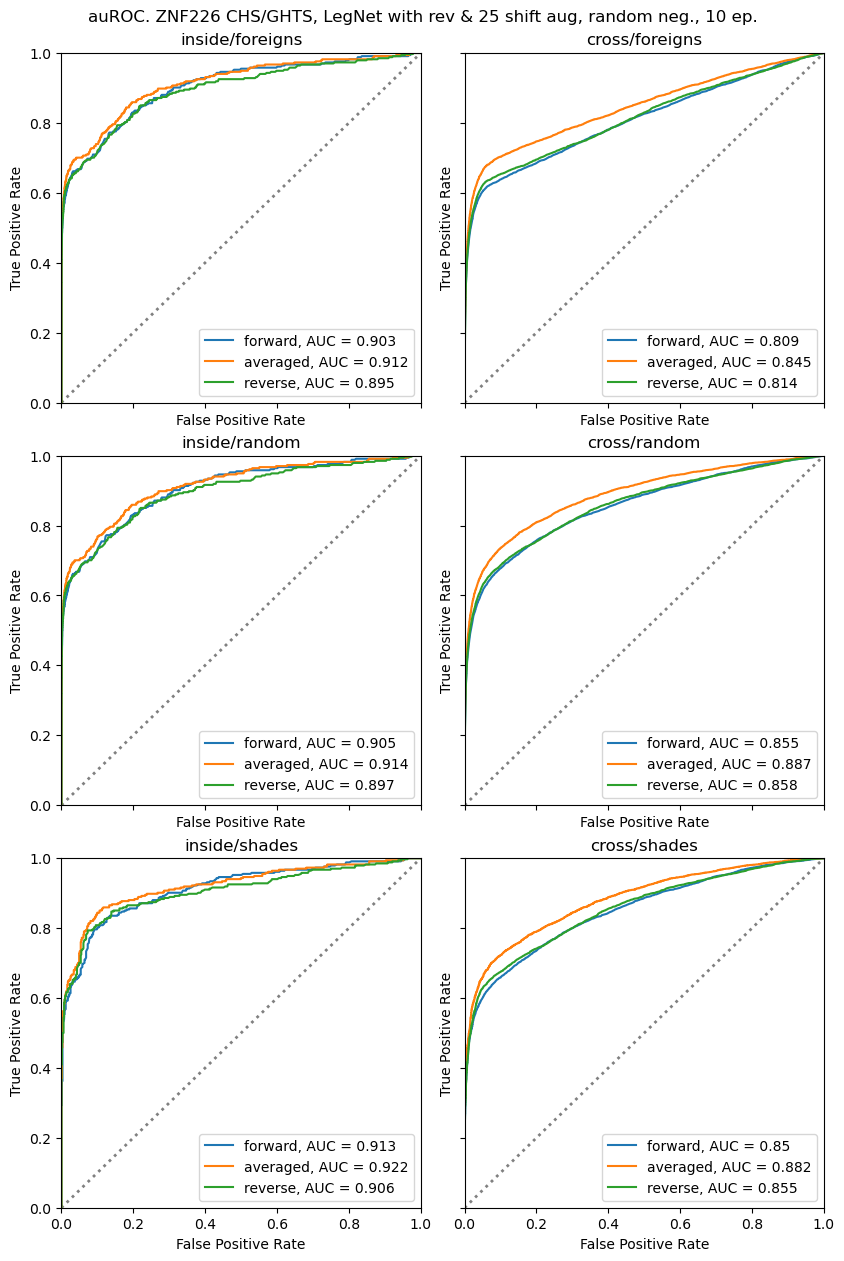

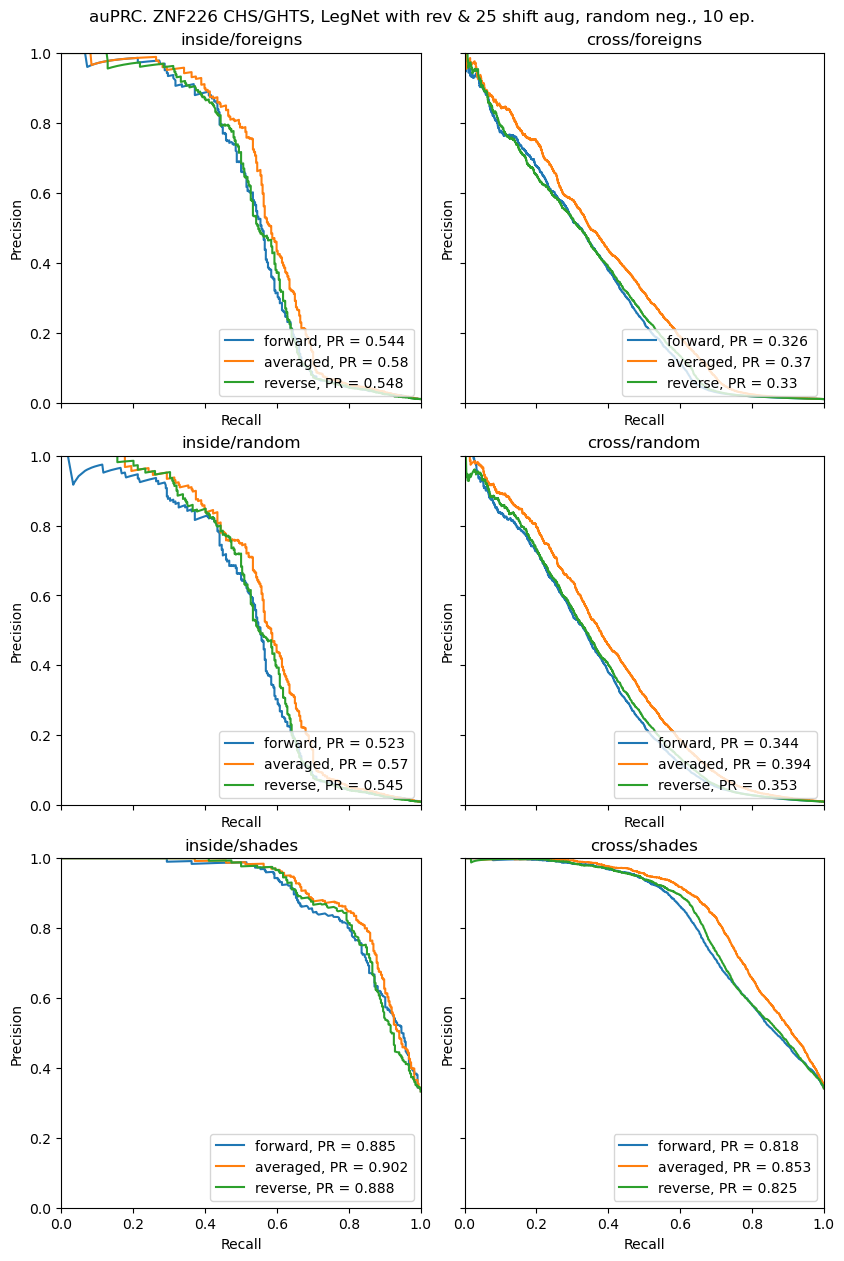

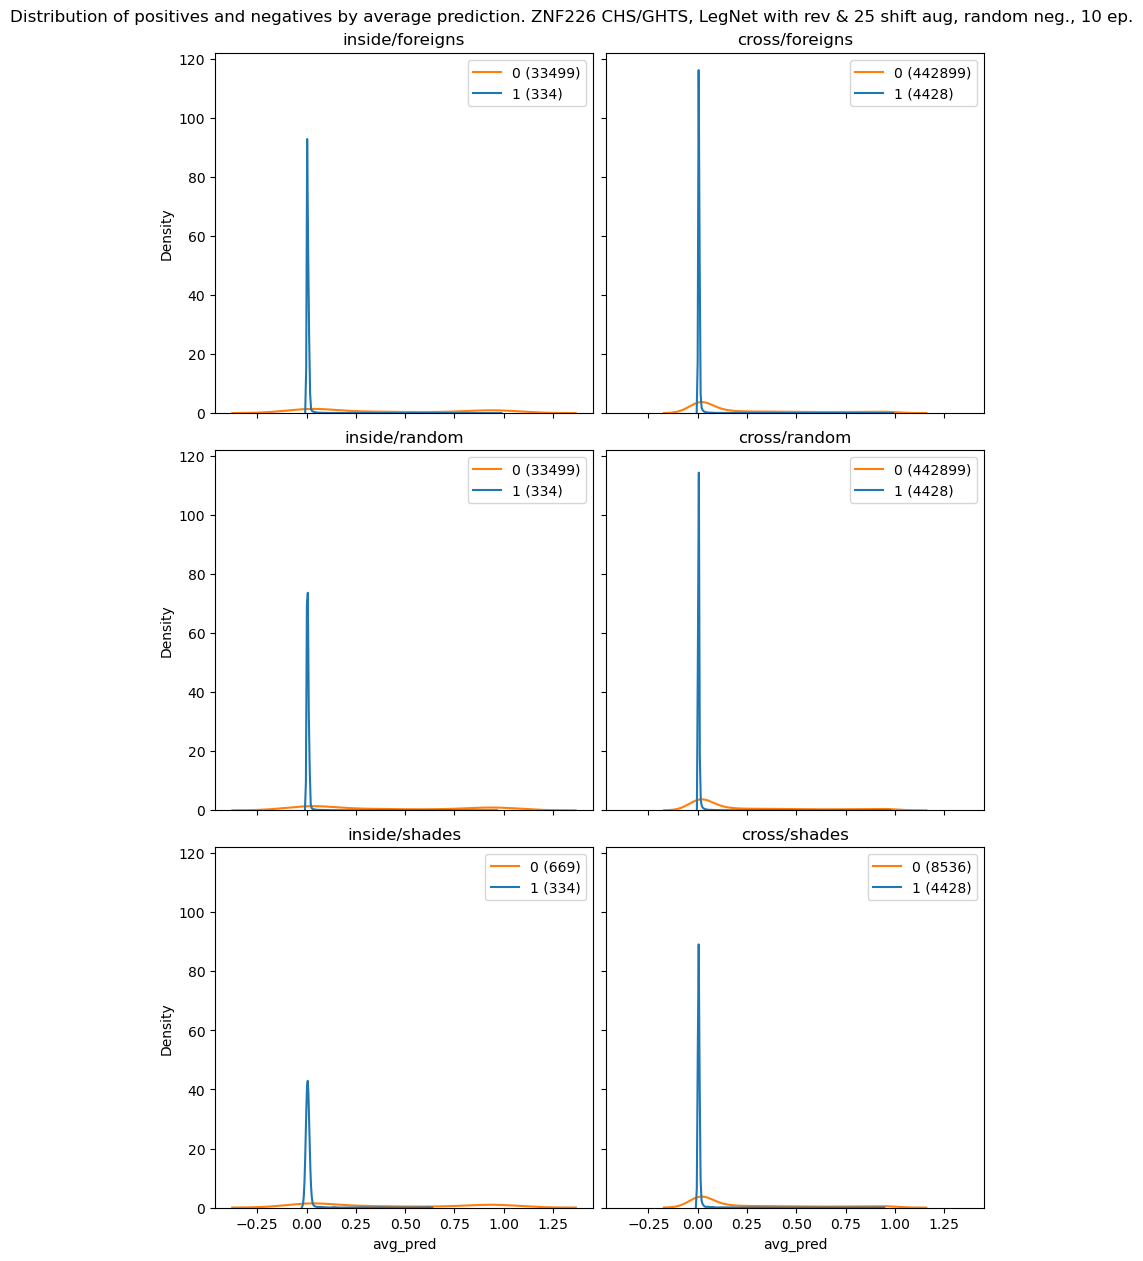

In [35]:
figsize = [x / 1.2 for x in (10, 15)]

fig_roc, axs_roc = plt.subplots(3, 2, figsize=figsize, layout='constrained',
                                sharex=True, sharey=True)
fig_roc.suptitle(f'auROC. {run_info}, {mod_info}')
fig_pr, axs_pr = plt.subplots(3, 2, figsize=figsize, layout='constrained',
                              sharex=True, sharey=True)
fig_pr.suptitle(f'auPRC. {run_info}, {mod_info}')
fig_distr, axs_distr = plt.subplots(3, 2, figsize=figsize, layout='constrained',
                                    sharex=True, sharey=True)
fig_distr.suptitle(f'Distribution of positives and negatives by average prediction. {run_info}, {mod_info}')
def get_ax(axs, split, negative):
    splits_int = {
        'inside': 0,
        'cross': 1
    }
    negatives_int = {
        'foreigns': 0,
        'random': 1,
        'shades': 2
    }
    split_int = splits_int[split]
    negative_int = negatives_int[negative]
    return axs[negative_int, split_int]

def get_title(split, negative):
    # return f'{split}-experiment, {negative} as negatives'
    return f'{split}/{negative}'

try:
    for preds_df, split, negative in process_multitesting_preds_df(path_to_preds):
        print(f'{split:*^32s}{negative:*^32s}')
        plot_roc(preds_df, split, negative, ax=get_ax(axs_roc, split, negative), title=get_title(split, negative))
        plot_pr(preds_df, split, negative, ax=get_ax(axs_pr, split, negative), title=get_title(split, negative))
        dist_ax = get_ax(axs_distr, split, negative)
        g = sns.kdeplot(preds_df, x="avg_pred", hue="class_", common_norm=False, ax=dist_ax)
        dist_ax.set_title(get_title(split, negative))
        dist_ax.legend(labels = [f'{x} ({n})' for x, n in preds_df['class_'].value_counts().items()])
        # plt.show()
        print('')
except Exception as ex:
    raise ex
plt.show()